In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from lib import *
import random

In [6]:
path_train_img = './data/train/'
path_train_mask = './data/train_mask/'
path_test = './data/test/'

## Посмотрим на данные

Набор из 1000+ фотографий людей (селфи, портрет). Качество фотографий заметно различается.
1315 фотографий в тестовой выборке, 145 в валидационной, 100 в тестовой.
Разрешение 320х240.

Выберем случайное изображение из тренировочной выборки и посмотрим на него и его маску.

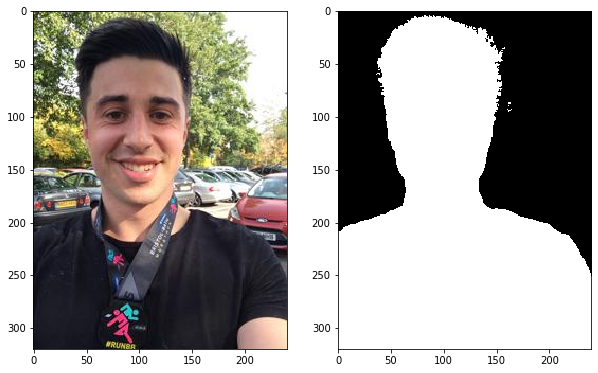

In [8]:
images = os.listdir(path_train_img)
index = np.random.choice(images).split('.')[0]
mask = cv2.imread(path_train_mask + '{}.png'.format(index))
plot_images(index, path_train_img, path_train_mask)

In [9]:
img = cv2.imread(path_train_img + '{}.jpg'.format(index))
img.shape, mask.shape

((320, 240, 3), (320, 240, 3))

In [10]:
np.mean(img), np.std(img)

(105.39386284722222, 74.99840983621156)

## Препроцессинг данных



В модель будет подаваться не весь массив изображений, а только случайно выбранные части, с заданным размером (batch_size). Размер батчей выбирается исходя из количества доступной оперативной памяти (у меня вытягивал только 12).

В тренировочной выборке 1315 изображений, что, на самом деле, очень мало. Для увеличения тренировочной выборки применяется метод аугментаций изображений - случайные повороты, сжатия, кропы. Такой метод позволяет улучшить качество модели без затрат на получение новых данных
([ссылка на репозиторий](https://github.com/albu/albumentations)). 

Зададим пути для выборок:

In [11]:
paths_to_imgs_train = sorted(glob('data/train/*'))
print('Неправльный путь: ', paths_to_imgs_train[5]) # В windows 10 glob() выдает недействительные пути
paths_to_imgs_train=[paths_to_imgs_train[i].replace('\\','/') for i in range(len(paths_to_imgs_train))]
print('Правильный путь:  ', paths_to_imgs_train[5])

paths_to_masks_train = sorted(glob('data/train_mask/*'))
paths_to_masks_train = [paths_to_masks_train[i].replace('\\','/') for i in range(len(paths_to_masks_train))]

paths_to_imgs_test = sorted(glob('data/valid/*'))
paths_to_imgs_test = [paths_to_imgs_test[i].replace('\\','/') for i in range(len(paths_to_imgs_test))]

paths_to_masks_test = sorted(glob('data/valid_mask/*'))
paths_to_masks_test = [paths_to_masks_test[i].replace('\\','/') for i in range(len(paths_to_masks_test))]

Неправльный путь:  data/train\1001.jpg
Правильный путь:   data/train/1001.jpg


Напишем генератор для подачи изобажений в нейросеть

In [12]:
#инитиализация аугментаций
from albumentations import (
    PadIfNeeded, HorizontalFlip, VerticalFlip, CenterCrop,    
    Crop, Compose, Transpose, RandomRotate90, ElasticTransform,
    GridDistortion, OpticalDistortion, RandomSizedCrop, OneOf, CLAHE,
    RandomBrightnessContrast, RandomGamma)


aug = Compose([    
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
          ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
          GridDistortion(p=0.5),
          OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)],
           p=0.8),
    CLAHE(p=0.8),
    RandomBrightnessContrast(p=0.8),    
    RandomGamma(p=0.8)])



Генератор выбирает случайные изображения, ресайзит, и аугментирует их в 224x224 и добавляет в тензор, который затем подается в модель

In [14]:
for x, y in generator(paths_to_imgs_train, paths_to_masks_train, 16):
    break

In [15]:
y[3].shape

(224, 224, 1)

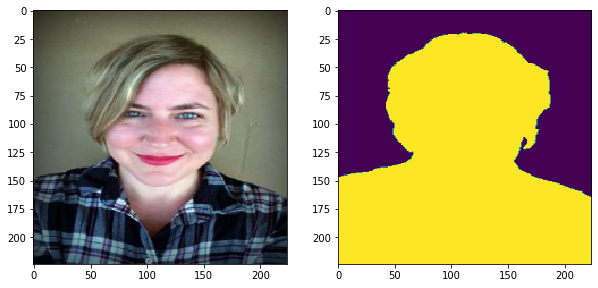

In [16]:
plot_image(x[3],y[3])

In [17]:
x.shape, y.shape

((16, 224, 224, 3), (16, 224, 224, 1))

## Модель

Используется модель Unet, за основу которой я взял аритектуру vgg16. Данный выбор обусловлен хорошим качеством архитектуры и её невысокой сложностью. 

https://arxiv.org/pdf/1505.04597.pdf

https://neurohive.io/ru/vidy-nejrosetej/vgg16-model/


In [18]:
import segmentation_models as sm #BFF
import keras
from segmentation_models import Unet
from keras.models import load_model


model = sm.Unet('resnet34', encoder_weights='imagenet')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]
results = model.fit_generator(generator(paths_to_imgs_train, paths_to_masks_train, 12),
                             steps_per_epoch=100,
                             epochs=60,
                             callbacks=callbacks,
                             validation_data=generator(paths_to_imgs_test, paths_to_masks_test, 12),
                             validation_steps=50                             
                             )

Epoch 1/60
100/100 [==============================] - 65s 648ms/step - loss: 0.6197 - iou_score: 0.7268 - val_loss: 0.9477 - val_iou_score: 0.7475
Epoch 2/60
100/100 [==============================] - 51s 507ms/step - loss: 0.4427 - iou_score: 0.8074 - val_loss: 0.7406 - val_iou_score: 0.6936
Epoch 3/60
100/100 [==============================] - 51s 507ms/step - loss: 0.4088 - iou_score: 0.8264 - val_loss: 0.5075 - val_iou_score: 0.8055
Epoch 4/60
100/100 [==============================] - 51s 509ms/step - loss: 0.3590 - iou_score: 0.8475 - val_loss: 0.4590 - val_iou_score: 0.8198
Epoch 5/60
100/100 [==============================] - 51s 508ms/step - loss: 0.3580 - iou_score: 0.8461 - val_loss: 0.4502 - val_iou_score: 0.8313
Epoch 6/60
100/100 [==============================] - 51s 509ms/step - loss: 0.3111 - iou_score: 0.8703 - val_loss: 0.4198 - val_iou_score: 0.8369
Epoch 7/60
100/100 [==============================] - 51s 508ms/step - loss: 0.3108 - iou_score: 0.8682 - val_loss: 0.

100/100 [==============================] - 51s 509ms/step - loss: 0.1313 - iou_score: 0.9441 - val_loss: 0.2457 - val_iou_score: 0.9056
Epoch 57/60
100/100 [==============================] - 51s 509ms/step - loss: 0.1302 - iou_score: 0.9444 - val_loss: 0.2472 - val_iou_score: 0.9095
Epoch 58/60
100/100 [==============================] - 51s 509ms/step - loss: 0.1304 - iou_score: 0.9437 - val_loss: 0.2481 - val_iou_score: 0.9061
Epoch 59/60
100/100 [==============================] - 51s 508ms/step - loss: 0.1301 - iou_score: 0.9459 - val_loss: 0.2628 - val_iou_score: 0.8996
Epoch 60/60
100/100 [==============================] - 51s 511ms/step - loss: 0.1259 - iou_score: 0.9464 - val_loss: 0.2206 - val_iou_score: 0.9163


In [ ]:
model.summary()

## Посмотим на предсказания модели

In [20]:
def generator_predict(paths_to_imgs, batch_size):
    while True:
        x_batch = []
        paths_to_imgs_tmp=[]
        for i in range(batch_size):
            #a=random.randint(1, batch_size)
            paths_to_imgs_tmp.append(paths_to_imgs[a])
        
        for path_to_img in paths_to_imgs_tmp:
            img = cv2.resize(cv2.imread(path_to_img), (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            x_batch.append(img)
        
        
        x_batch = np.array(x_batch) 

        
        yield x_batch

In [21]:
paths_to_imgs_test = sorted(glob('data/test/*'))
paths_to_imgs_test = [paths_to_imgs_test[i].replace('\\','/') for i in range(len(paths_to_imgs_test))]


for x in generator_predict(paths_to_imgs_test, len(paths_to_imgs_test):
    break

In [22]:
pred=model.predict(x)


In [ ]:
plot_image(x[77], pred[77])

## Оценка модели

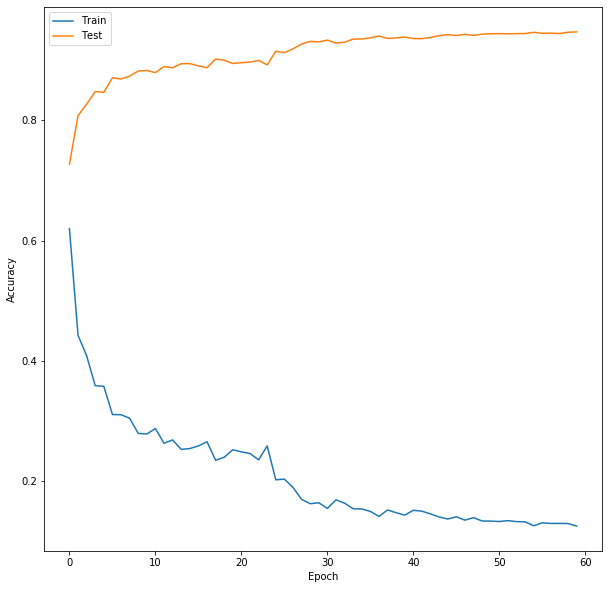

In [28]:
plot_losses(results)

In [29]:
model.load_weights('best_model.h5')

In [ ]:
scores = model.evaluate_generator(generator(paths_to_imgs_train, paths_to_masks_train, 12), steps=12)

In [ ]:
print("Loss: {:.5}".format(scores[0]))
print("iou_score: {:.5}".format(scores[1:]))

## Отправка результата

In [ ]:
paths_to_masks_test = sorted(glob('data/predict/*'))
paths_to_masks_test = [paths_to_masks_test[i].replace('\\','/') for i in range(len(paths_to_masks_test))]

In [ ]:
#запишемданные в data/predict
for i, x in enumerate(pred):
    cv2.inwrite('data/predict/{}.jpg'.format(i), x)

In [ ]:
#создаем html файл с предсказаниями
paths_to_imgs = sorted(glob("data/test/*"))
pred_masks = [np.array(Image.open(path)) for path in sorted(glob("data/predict/*"))]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example")

In [ ]:
pred_rle = []
for img in pred:      
    img = cv2.resize(img, (320, 240))
    tmp = np.copy(img)
    tmp[tmp<np.mean(img)] = 0
    tmp[tmp>0] = 1
    pred_rle.append(rle_encoder(tmp))

In [ ]:
sub = pd.read_csv( 'data/pred_valid_template' )
for fn, rle in zip(paths_to_imgs, pred_rle):
    sub['EncodedPixels'][sub['ImageId_ClassId'].apply(lambda x: x.split('_')[0]) == fn] = rle

In [ ]:
sub.to_csv('pred_valid.csv', index=False)